In [1]:
import numpy as np
import cv2
import imutils

from skimage.feature import peak_local_max
from skimage.morphology import watershed
from scipy import ndimage

from skimage import io
from matplotlib import pyplot as plt
from PIL import ImageEnhance, Image

from utils import cv2_imshow as imshow

In [2]:
[t1, t2, t3, t4, t5, t6] = [cv2.imread(f"images/text{i}.jpg") for i in range(1, 7)]

In [3]:
def separate_text(image, th, iterations=5, k_size=(9, 3), adaptiveTh=(15, 5)):
    img = image.copy()
    img_final = image.copy()

    img2gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(img2gray, th, 255, cv2.THRESH_BINARY)
    image_final = cv2.bitwise_and(img2gray, img2gray, mask=mask)

    is_dark = np.mean(img2gray) < th

    # for black text , cv.THRESH_BINARY_INV
    ret, new_img = cv2.threshold(
        image_final, 0, 255, cv2.THRESH_BINARY if is_dark else cv2.THRESH_BINARY_INV
    )

    # to manipulate the orientation of dilution,
    # large x means horizonatally dilating  more,
    # large y means vertically dilating more
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, k_size)
    # dilate , more the iteration more the dilation
    dilated = cv2.dilate(new_img, kernel, iterations=iterations)

    # findContours returns 2 variables for getting contours
    contours, hierarchy = cv2.findContours(
        dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
    )

    result = np.full((img.shape[0], img.shape[1]), 255, dtype=np.uint8)

    for contour in contours:
        # get rectangle bounding contour
        [x, y, w, h] = cv2.boundingRect(contour)

        # Don't plot small false positives that aren't text
        r = float(cv2.countNonZero(mask[y : y + h, x : x + w])) / (w * h)
        if r < 0.45 or w < 5 or h < 5 or (np.abs(1 - w / h) < 0.1):
            continue

        rect = img2gray[y : y + h - 1, x : x + w - 1]
        if np.mean(rect) > np.median(rect) or is_dark:
            # Inverse image
            rect = 255 - rect

        rect_thresholded = cv2.adaptiveThreshold(
            rect, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, *adaptiveTh
        )

        result[y : y + h - 1, x : x + w - 1] = cv2.fastNlMeansDenoising(
            rect_thresholded, None, 60, 7, 15
        )
    return result

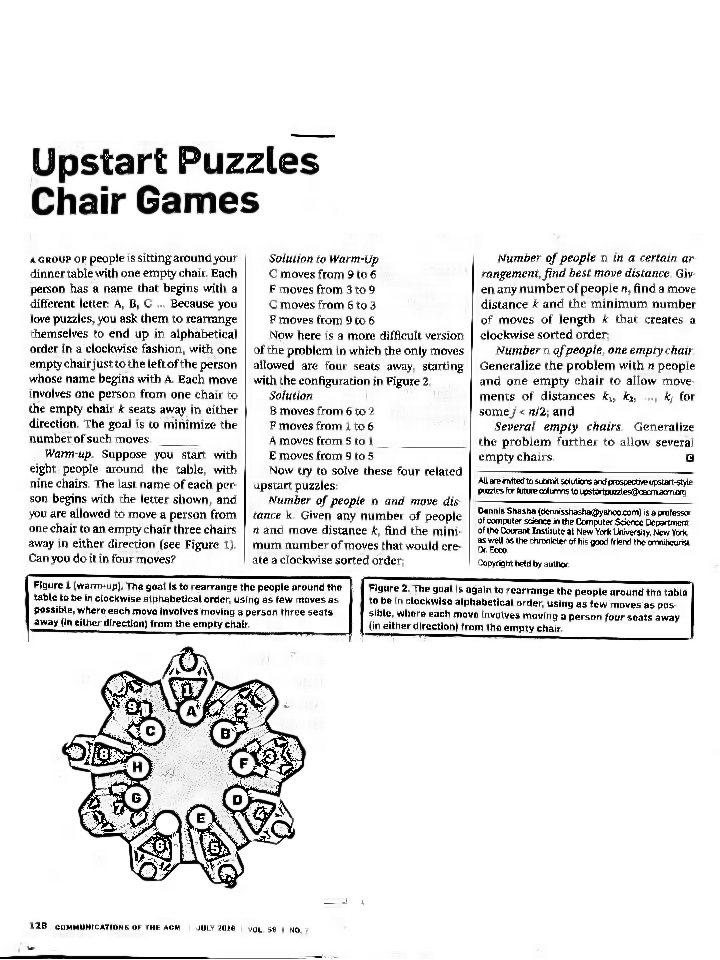

In [4]:
imshow(separate_text(t1, th=150.0, adaptiveTh=(11, 5)))

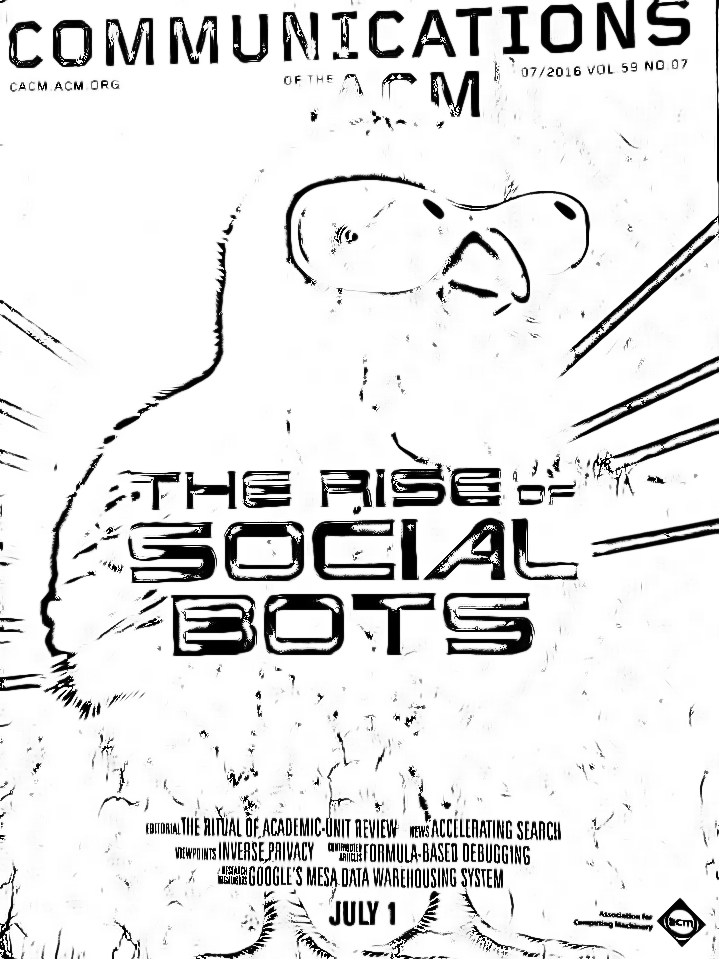

In [5]:
imshow(separate_text(t2, th=87, adaptiveTh=(31, 11)))

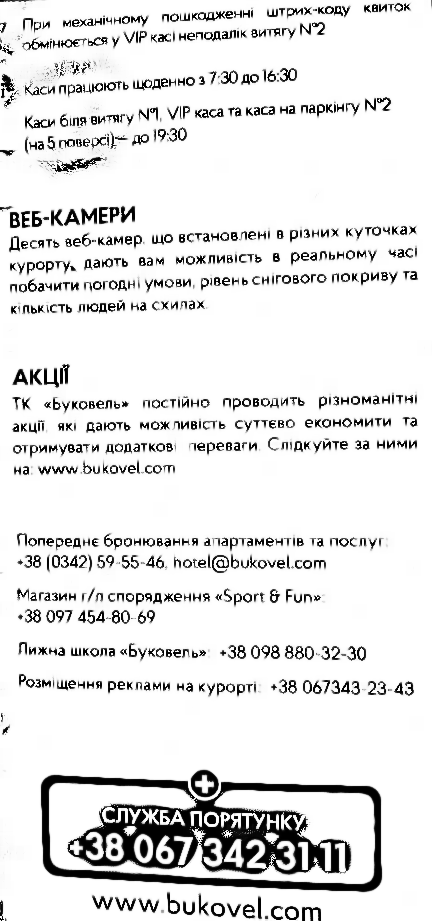

In [13]:
imshow(separate_text(t3, th=60, iterations=35, k_size=(5, 3), adaptiveTh=(41, 20)))

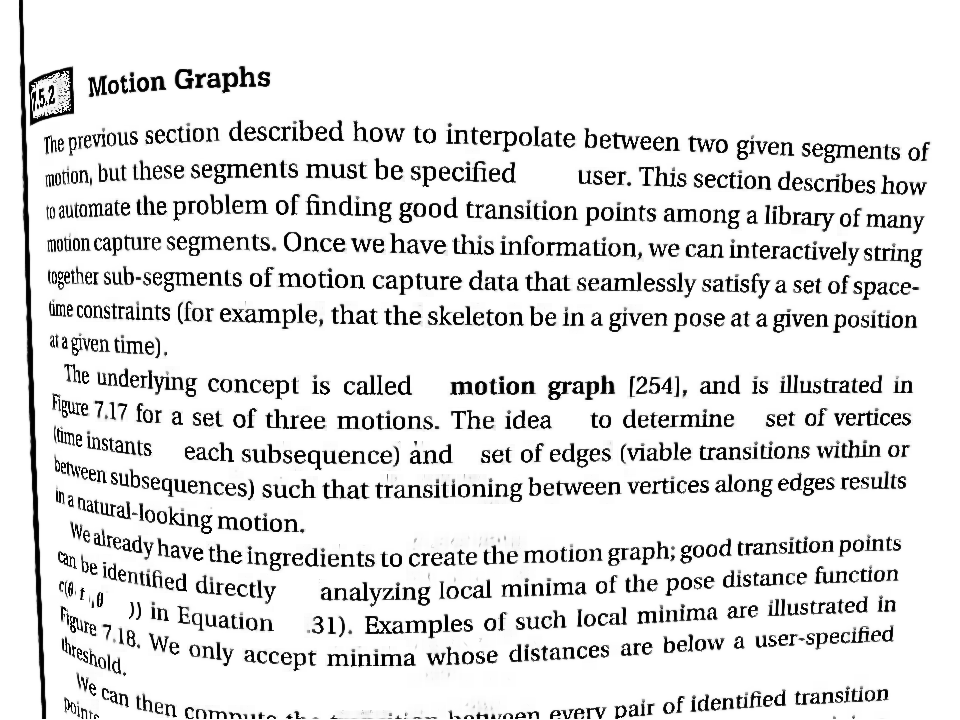

In [7]:
imshow(separate_text(t4, th=110, iterations=3, k_size=(3, 3)))

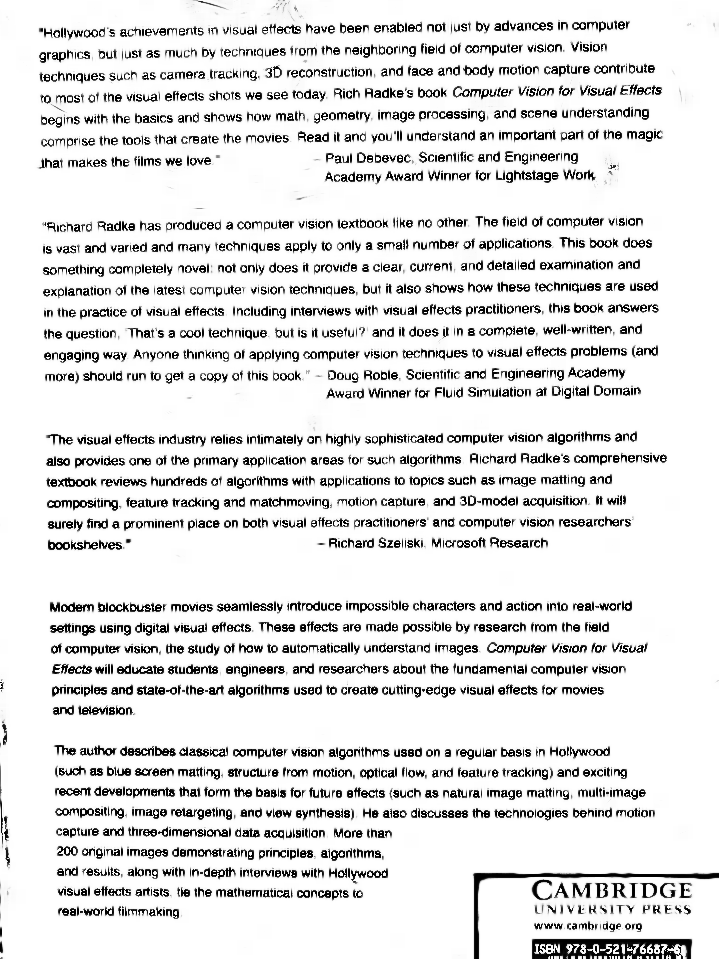

In [8]:
imshow(separate_text(t5, th=55, iterations=100, k_size=(5, 3), adaptiveTh=(41, 24)))

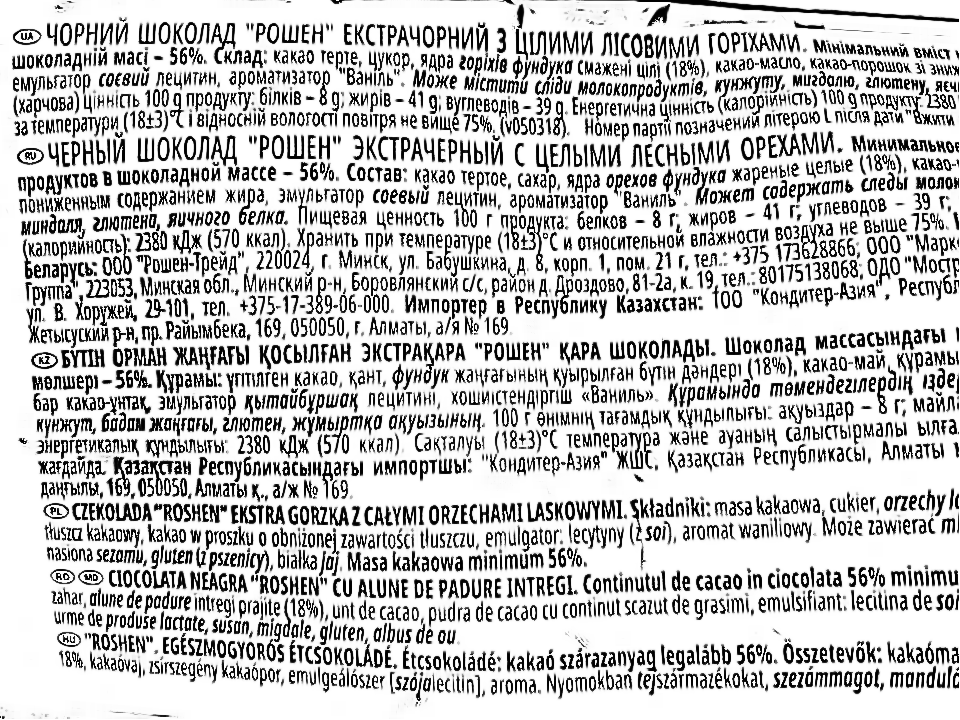

In [9]:
imshow(separate_text(t6, th=55, iterations=20, adaptiveTh=(25, 12)))